# Occupancy Detection from RPi
Using CO$_2$ data from the BEVO Beacon to estimate occupancy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math

from datetime import datetime, timedelta

# Data Import
We need all the BEVO Beacon's measurements of the CO$_2$ concentration, but we might also consider metrics like TVOCs, Temperature, and RH.

In [2]:
beacon = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)

In addition, we need the filtered dataset to compare readings to.

In [29]:
beacon_filtered = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)

Fitbit data will be needed to look at sleep periods.

In [4]:
fitbit = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv",parse_dates=["start_time","end_time","date"],infer_datetime_format=True)

# Simple Occupancy Estimation
We can start by simply looking at nights that we _know_ the participant is home and occupying the space. Then we can use that information to determine other nights when the participant would have been asleep in their bedroom by comparing, as a start, the median/mean concentration.

In [271]:
class co2_inspection:
    
    def __init__(self,pt,data_dir="../"):
        self.pt = pt # beiwe id
        # beacon data
        complete = pd.read_csv(f"{data_dir}data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],infer_datetime_format=True)
        filtered = pd.read_csv(f"{data_dir}data/processed/beacon_by_night-ux_s20.csv",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
        self.complete = complete[complete["beiwe"] == self.pt]
        self.filtered = filtered[filtered["beiwe"] == self.pt]
        self.filtered = self.filtered[(self.filtered["home"] == 1) | (self.filtered["increasing_co2"] > 0.5)]
        self.s = pd.Series(self.filtered["start_time"].unique())
        # fitbit data
        fitbit = pd.read_csv(f"{data_dir}data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
        self.sleep = fitbit[fitbit["beiwe"] == self.pt]
        # gps data
        gps = pd.read_csv(f"{data_dir}data/processed/beiwe-gps-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
        self.gps = gps[gps["beiwe"] == self.pt]
        # beacon data derivatives
        #self.set_morning_beacon_data()
        #self.set_beacon_before_sleep()
        #self.set_increasing_periods(self.complete,"co2")
        #self.set_increasing_periods(self.filtered,"co2")
        #self.set_increasing_only()
        #self.set_beacon_by_sleep()
        #self.set_beacon_while_occupied()
        #self.set_beacon_gps_occupied()
        
    def set_morning_beacon_data(self,time_column="timestamp",num_hours=3):
        """gets the beacon data from the morning"""
        morning_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for wake_time in self.filtered['end_time'].unique():
            temp = all_data[wake_time:pd.to_datetime(wake_time)+timedelta(hours=num_hours)]
            temp['start_time'] = wake_time
            morning_df = morning_df.append(temp)

        self.morning = morning_df.reset_index()
        
    def set_beacon_before_sleep(self,time_column="timestamp",num_hours=1):
        """sets beacon data prior to sleeping"""
        prior_to_sleep_df = pd.DataFrame()
        all_data = self.complete.copy()
        all_data.set_index(time_column,inplace=True)
        for sleep_time in self.filtered['start_time'].unique():
            temp = all_data[pd.to_datetime(sleep_time)-timedelta(hours=num_hours):pd.to_datetime(sleep_time)+timedelta(hours=1)]
            temp['end_time'] = sleep_time
            prior_to_sleep_df = prior_to_sleep_df.append(temp)

        self.prior = prior_to_sleep_df.reset_index()
        
    def plot_timeseries(self,df,variable,time_column="timestamp",re=False,**kwargs):
        """plots timeseries of the given variable"""
        fig, ax = plt.subplots(figsize=(24,4))
        try:
            if "time_period" in kwargs.keys():
                df = df.set_index(time_column)[kwargs["time_period"][0]:kwargs["time_period"][1]].reset_index()
            # plotting
            ax.scatter(df[time_column],df[variable],color="black",s=10)
            # formatting
            if "event" in kwargs.keys():
                ax.axvline(kwargs["event"],linestyle="dashed",linewidth=3,color="firebrick")
            if "ylim" in kwargs.keys():
                ax.set_ylim(kwargs["ylim"])
                
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)

            if re:
                return ax
            
            plt.show()
            plt.close()
        except Exception as e:
            print(e)
            
    def plot_individual_days(self,dataset,variable="co2",**kwargs):
        """plots the individual days"""
        t = "start_time" if "start_time" in dataset.columns else "end_time"
        print(t)
        for event in dataset[t].unique():
            timeseries(dataset[dataset[t] == event],variable,event=pd.to_datetime(event),**kwargs)
            
    def set_increasing_periods(self,dataset,variable,averaging_window=60,increase_window=5,stat="mean",plot=False):
        """finds increasing periods"""
         # smooting data
        if stat == "mean":
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).mean()
        else:
            dataset[f"sma_{variable}"] = dataset[variable].rolling(window=averaging_window,center=True,min_periods=int(averaging_window/2)).median()
        dataset["dC"] = dataset[f"sma_{variable}"] - dataset[f"sma_{variable}"].shift(1) # getting dC
        dataset["sma_dC"] = dataset["dC"].rolling(window=increase_window).mean() # getting moving average of increases
        inc = []
        for value in dataset["sma_dC"]:
            if math.isnan(value):
                inc.append(np.nan)
            elif value > 0:
                inc.append(1)
            else:
                inc.append(0)
        dataset["increasing"] = inc
        #dataset["increasing"] = [1 if value > 0 else 0 for value in dataset["sma_dC"]] # creating column for increasing concentration
        
        if plot:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.scatter(self.complete["timestamp"],self.complete[variable],color="black",s=10,alpha=0.7,zorder=1)
            inc = dataset[dataset["increasing"] == 1]
            ax.scatter(inc["timestamp"],inc[variable],color="seagreen",s=5,zorder=2)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
                
    def set_increasing_only(self):
        """beacon data over increasing periods only"""
        self.inc = self.complete[self.complete["increasing"] == 1]
    
    def set_beacon_by_sleep(self):
        """beacon data during sleep events"""
        beacon_by_fitbit = pd.DataFrame()
        for s, e in zip(self.filtered["start_time"].unique(),self.filtered["end_time"].unique()):
            beacon_temp = self.complete.set_index("timestamp")[pd.to_datetime(s):pd.to_datetime(e)].reset_index()
            beacon_temp["start_time"] = s
            beacon_temp["end_time"] = e
            beacon_by_fitbit = beacon_by_fitbit.append(beacon_temp)
            
        self.beacon_during_sleep = beacon_by_fitbit
        
    def set_beacon_while_occupied(self,threshold=0.75):
        """beacon data when the bedroom is occupied"""
        beacon_percent = self.beacon_during_sleep.drop(["sma_co2","dC","sma_dC","increasing"],axis="columns").merge(right=self.beacon_during_sleep.groupby("start_time").mean().reset_index()[["increasing","start_time"]],on="start_time",how="left")
        self.occupied = beacon_percent[beacon_percent["increasing"] > threshold]
        
    def set_beacon_gps_occupied(self):
        """beacon data when occupied or gps confirms home"""
        self.fully_filtered = self.filtered.append(self.occupied).drop_duplicates(subset=["beiwe","timestamp"])
        
    def plot_overlap(self, **kwargs):
        fig, t_ax = plt.subplots(figsize=(29,6))
        # temperature axis
        try:
            t_ax.scatter(self.complete["timestamp"],self.complete["temperature_c"],color="cornflowerblue",s=5,marker="s")
        except AttributeError:
            print("no temperature data")
        plt.xticks(rotation=-30,ha="left")
        ## y-axis
        t_ax.set_ylim([10,40])
        t_ax.set_ylabel("Temperature (C)",fontsize=14)
        t_ax.yaxis.label.set_color('cornflowerblue')
        t_ax.tick_params(axis='y', colors='cornflowerblue',labelsize=12) 
        # co2 axis
        ax = t_ax.twinx()
        ## sleep events
        night_counter = 0
        if "time_period" in kwargs.keys():
            starting = kwargs["time_period"][0]
            ending = kwargs["time_period"][1]
        else:
            starting = datetime(1900,1,1)
            ending = datetime(2021,1,1)
        for s, e in zip(self.filtered["start_time"].unique(),self.filtered["end_time"].unique()):
            if pd.to_datetime(s) > starting and pd.to_datetime(e) < ending:
                ax.text(pd.to_datetime(s),np.nanmax(self.complete["co2"]),str(night_counter),fontsize=16,ha="left",va="top")
                ax.axvspan(pd.to_datetime(s),pd.to_datetime(e),color="grey",alpha=0.25,zorder=1)
            night_counter += 1
        ## beacon data
        ax.scatter(self.complete["timestamp"],self.complete["co2"],color="grey",alpha=0.5,s=5,zorder=2,label="Raw Data") # raw
        gps_filtered = self.filtered[self.filtered["home"] == 1]
        ax.scatter(gps_filtered["timestamp"],gps_filtered["co2"],s=20,color="firebrick",zorder=5, label="GPS Confirms Home") # gps filtered
        co2_filtered = self.filtered[self.filtered["increasing_co2"] > 0.5]
        ax.scatter(co2_filtered["timestamp"],co2_filtered["co2"],s=5,color="goldenrod",zorder=6, label="Increasing CO$_2$") # co2 filtered
        ## x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.xticks(rotation=-30,ha="left")
        if "time_period" in kwargs.keys():
            ax.set_xlim([kwargs["time_period"][0],kwargs["time_period"][1]])
        # y-axis
        ax.set_ylabel("CO$_2$ Concentration (ppm)",fontsize=14)
        ax.yaxis.label.set_color('gray')
        ax.tick_params(axis='y',colors="gray", labelsize=12) 
        # remainder
        ax.spines["top"].set_visible(False)
        ax.legend(frameon=False,loc="upper center",bbox_to_anchor=(0.5,-0.1),ncol=3)

        plt.show()
        plt.close()
            
    def run(self):
        """runs the analysis"""
        for dataset, label in zip([self.complete,self.filtered,self.prior,self.morning],["Complete","Filtered","Before Sleep","After Waking"]):
            print(label)
            self.plot_timeseries(dataset,"co2")

## All Participants
Based on some of the findings above, it is worthwhile to run the analysis for all participants.

In [328]:
print(sorted(beacon_filtered["beiwe"].unique()))
print(len(beacon_filtered["beiwe"].unique()))

['4i7679py', '745vq78e', '9jtzsuu8', '9xmhtq74', 'awa8uces', 'e73a1pd5', 'hxj6brwj', 'i31pt4b4', 'i4w8dx6l', 'idbkjh8u', 'itmylz3g', 'kyj367pi', 'lkkjddam', 'nvtfpaor', 'olaxadz5', 'qh34m4r9', 'rnse61g4', 'tlmlq19s', 'tmexej5v', 'vr9j5rry', 'xdbdrk6e', 'xlw5ntd5', 'zdpffrox']
23


In [329]:
bad_nights = {beiwe: [] for beiwe in beacon_filtered["beiwe"].unique()}

### 4i7679py

In [330]:
fi = co2_inspection(pt="4i7679py")

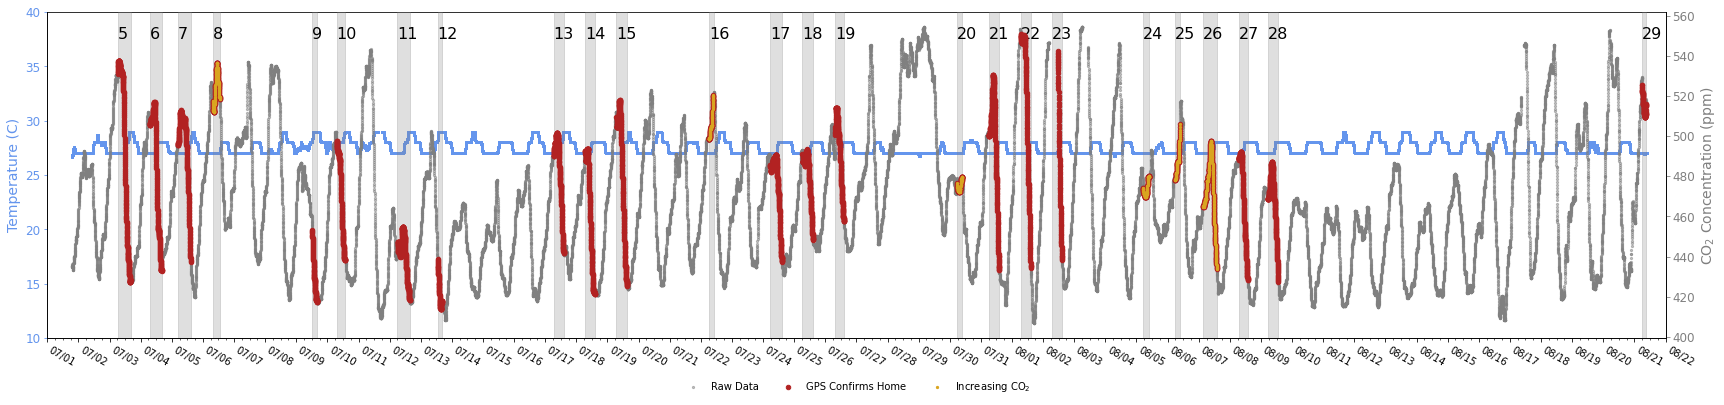

In [331]:
fi.plot_overlap(time_period=[datetime(2020,7,1),datetime(2020,8,22)])

In [332]:
bad_nights["4i7679py"] = fi.s.iloc[[5,6,7,9,10,11,12,13,14,15,17,18,19,21,22,23,26,27,28]].values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon

</div>

### 745vq78e

In [333]:
s4 = co2_inspection(pt="745vq78e")

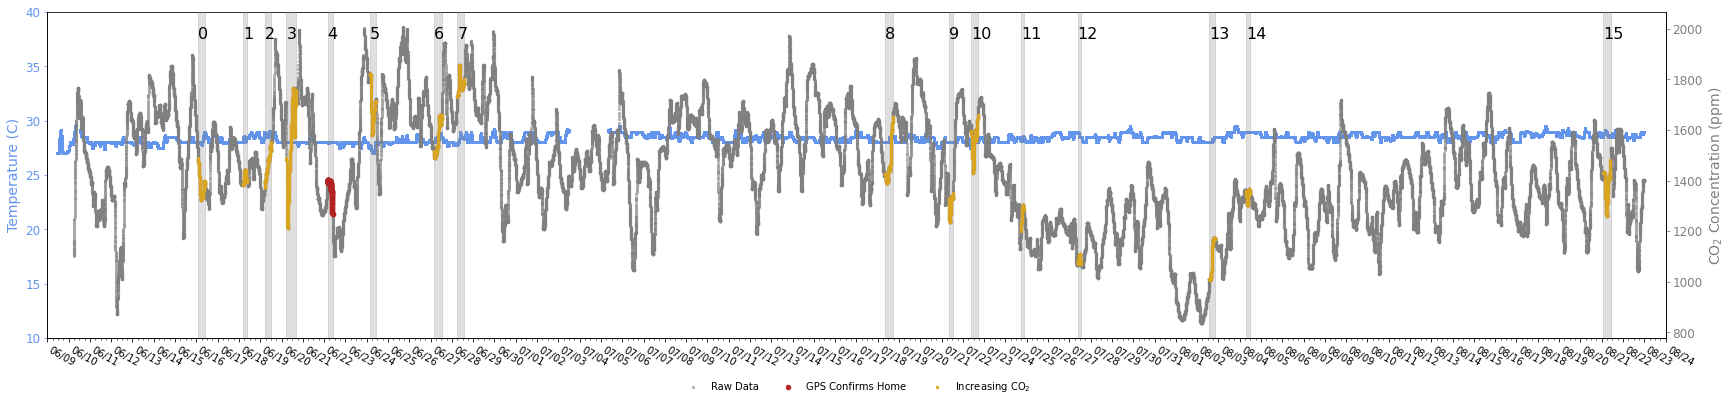

In [334]:
s4.plot_overlap(time_period=[datetime(2020,6,9),datetime(2020,8,24)])

<div class="alert-block alert alert-success">
    
Data makes sense when looking more closely at the temperature/ventilation

</div>

### 9jtzsuu8

In [335]:
nj = co2_inspection(pt="9jtzsuu8")

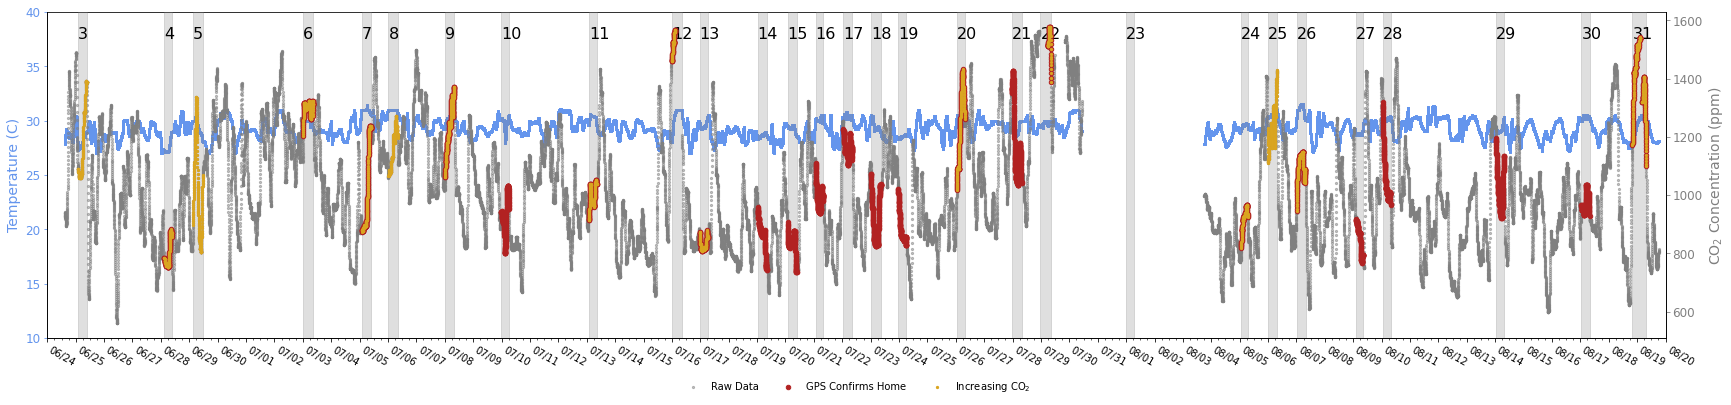

In [336]:
nj.plot_overlap(time_period=[datetime(2020,6,24),datetime(2020,8,20)])

In [337]:
bad_nights["9jtzsuu8"] = nj.s.iloc[[19,27,28]].values

<div class="alert-block alert alert-warning">
    
Data requires more review - there are times when the `co2` is increasing and other times when it is decreasing during sleep events.

</div>

### 9xmhtq74

In [338]:
nx = co2_inspection("9xmhtq74")

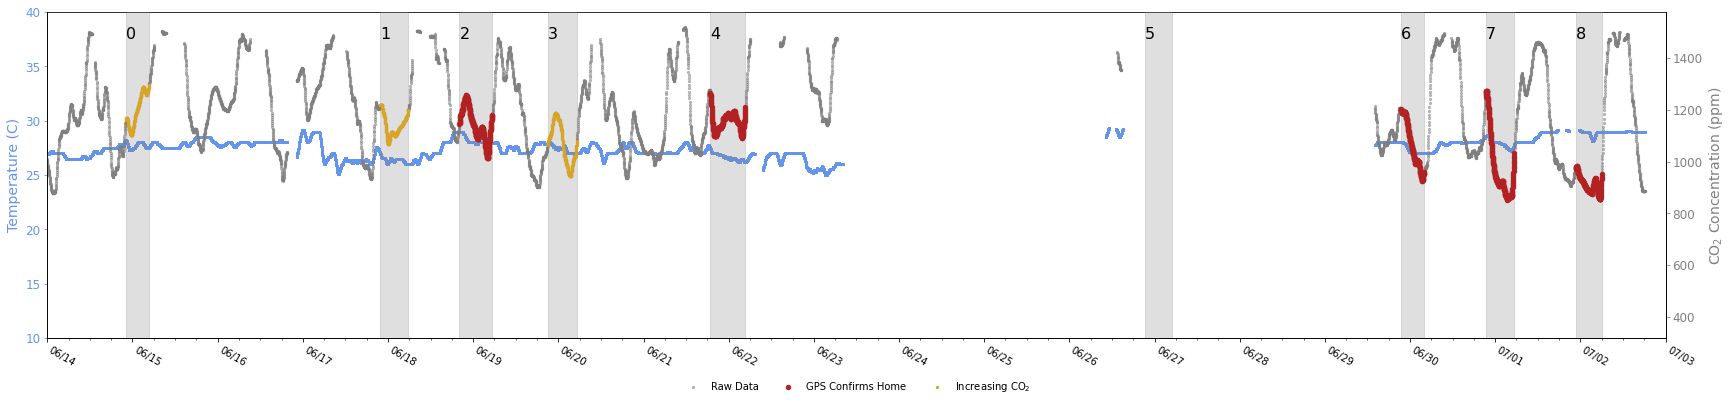

In [339]:
nx.plot_overlap(time_period=[datetime(2020,6,14),datetime(2020,7,3)])

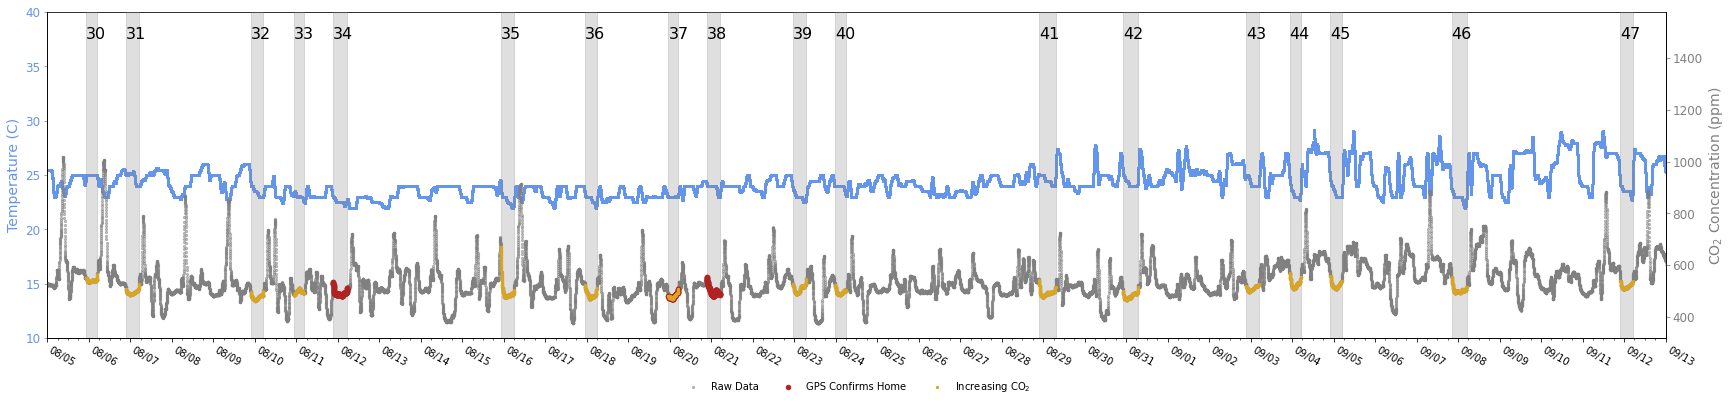

In [340]:
nx.plot_overlap(time_period=[datetime(2020,8,5),datetime(2020,9,13)])

In [341]:
bad_nights["9xmhtq74"] = nx.s.values

<div class="alert-block alert alert-danger">
    
The data isn't very clear but based on the spikes, it seems very likely that the device is not in the bedroom.

</div>

### awa8uces

In [342]:
aw = co2_inspection("awa8uces")

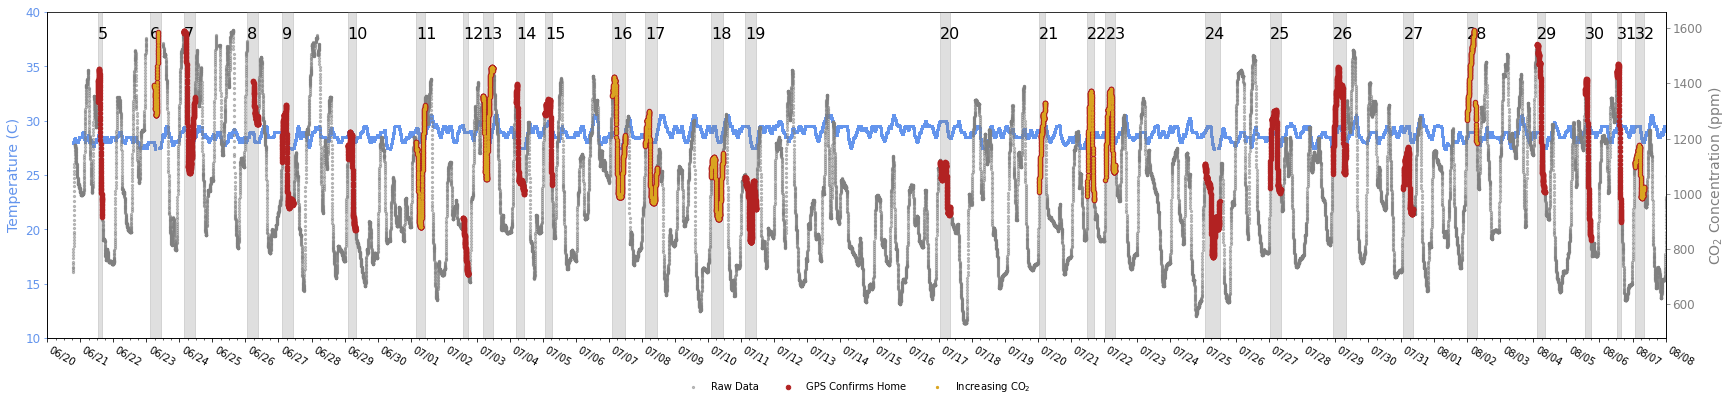

In [343]:
aw.plot_overlap(time_period=[datetime(2020,6,20),datetime(2020,8,8)])

In [345]:
bad_nights["awa8uces"] = aw.s.iloc[[12,]].values

In [ ]:
sleep = pd.read_csv("../data/processed/fitbit-sleep_daily-ux_s20.csv")
sleep_check = sleep[sleep["beiwe"] == "awa8uces"]

<div class="alert-block alert alert-warning">
    
Looks like another living room beacon, but it isn't super clear.

</div>

### e73a1pd5

In [211]:
e7 = co2_inspection("e73a1pd5")

In [212]:
e7.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,8,8)])

In [ ]:
sleep_check = sleep[sleep["beiwe"] == "e73a1pd5"]
sleep_check[sleep_check["main_sleep"] == False]

<div class="alert-block alert alert-success">
    
These data look fine, but the non-main sleep needs to be removed in the source code.

</div>

### hxj6brwj

In [284]:
hx = co2_inspection("hxj6brwj")

In [285]:
hx.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

In [286]:
hx.plot_overlap(time_period=[datetime(2020,7,10),datetime(2020,7,22)])

In [346]:
bad_nights["hxj6brwj"] = hx.s.values

<div class="alert-block alert alert-danger">
    
After a closer look, we might not want to include data from this participant at all. There are recurrent spikes in `co2` at around 18:00 every day which makes me think the concentration spikes when they get home for the day so the beacon would be in the living room. The new night that we were able to get has GPS data confirming they are _not_ home so we shouldn't even include that data point.

</div>

### i31pt4b4

In [214]:
i3 = co2_inspection("i31pt4b4")

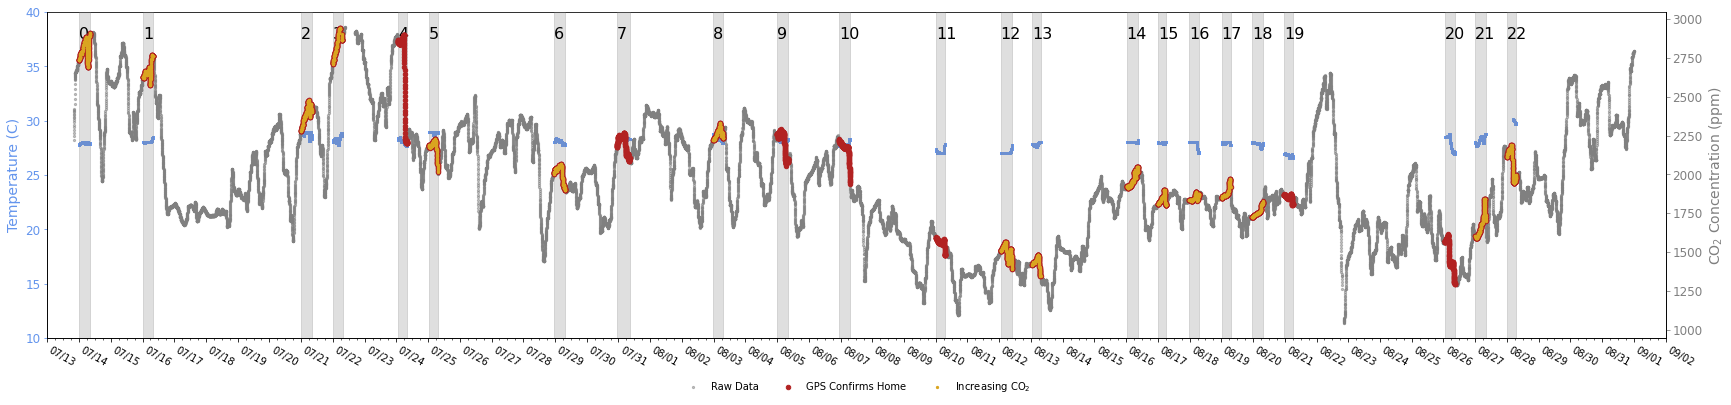

In [215]:
i3.plot_overlap(time_period=[datetime(2020,7,13),datetime(2020,9,2)])

<div class="alert-block alert alert-success">
    
These data look decent

</div>

### i4w8dx6l

In [216]:
i4 = co2_inspection(pt="i4w8dx6l")

In [217]:
i4.plot_overlap(time_period=[datetime(2020,6,1),datetime(2020,9,1)])

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 2088x432 with 2 Axes>

In [162]:
i4.plot_overlap(time_period=[datetime(2020,7,26),datetime(2020,7,31)])

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 2088x432 with 2 Axes>

In [347]:
bad_nights["i4w8dx6l"] = i4.s.values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon, and there are no GPS data.

</div>

### idbkjh8u

In [220]:
ib = co2_inspection(pt="idbkjh8u")

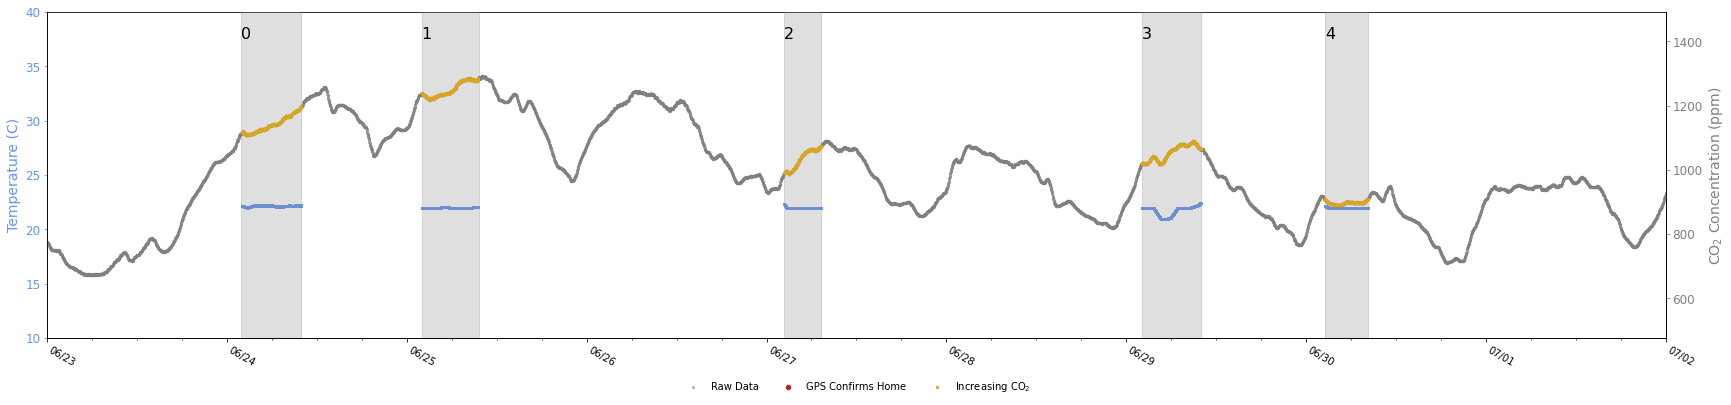

In [221]:
ib.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,7,2)])

<div class="alert-block alert alert-success">
    
Looks like we got two more nights of data!

</div>

### itmylz3g

In [222]:
it = co2_inspection("itmylz3g")

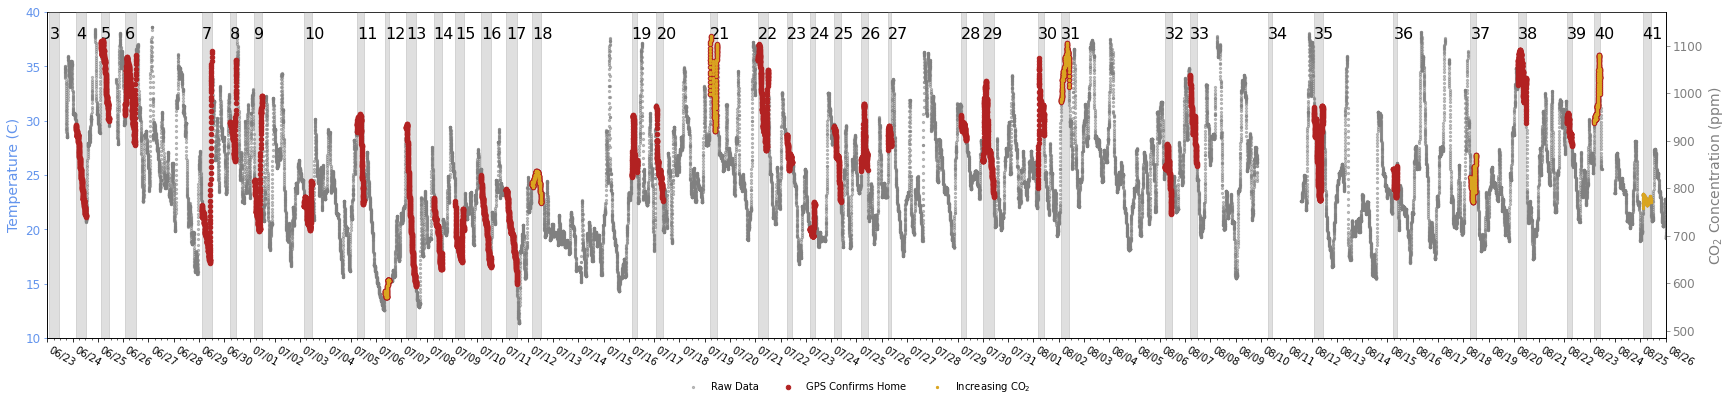

In [223]:
it.plot_overlap(time_period=[datetime(2020,6,23),datetime(2020,8,26)])

In [348]:
bad_nights["itmylz3g"] = it.s.iloc[[4,5,12,13,14,16,17,25,28,32,33]].values

<div class="alert-block alert alert-danger">
    
Looks like another living room beacon.

</div>

### kyj367pi

In [288]:
ky = co2_inspection("kyj367pi")

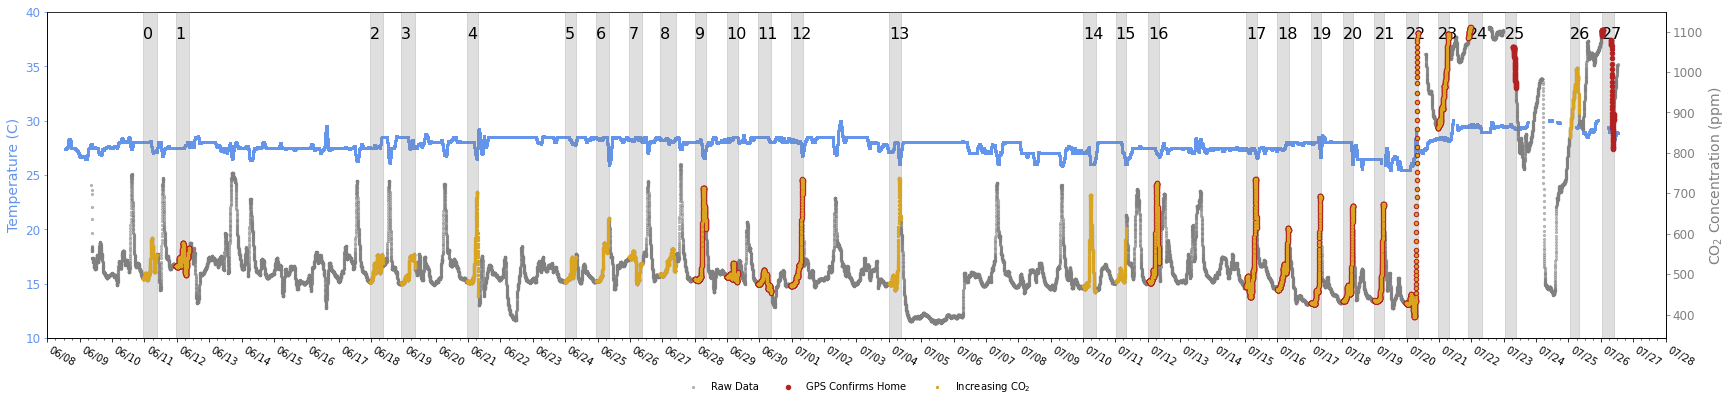

In [289]:
ky.plot_overlap(time_period=[datetime(2020,6,8),datetime(2020,7,28)])

In [349]:
bad_nights["kyj367pi"] = ky.s.iloc[[25,27]].values

<div class="alert-block alert alert-warning">
    
It looks like we got a few more nights, but pretty troubling results. Again it seems like the beacon might not be in the bedroom.
    
</div>

### lkkjddam

In [227]:
lk = co2_inspection("lkkjddam")

In [232]:
lk.plot_overlap(time_period=[datetime(2020,6,10),datetime(2020,8,10)])

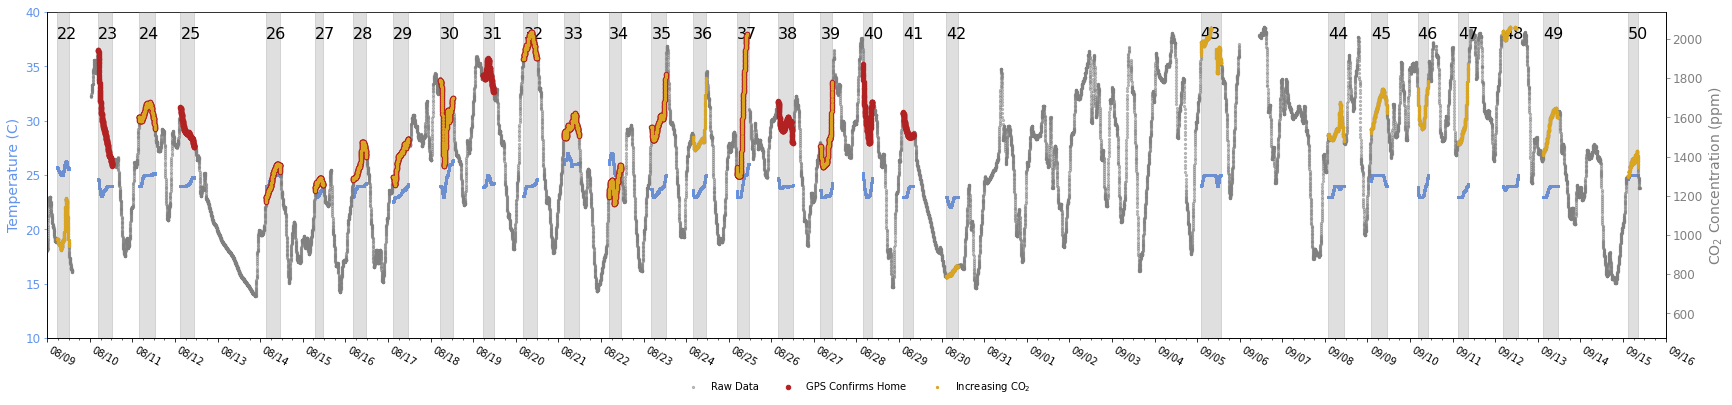

In [231]:
lk.plot_overlap(time_period=[datetime(2020,8,9),datetime(2020,9,16)])

<div class="alert-block alert alert-success">
    
Data look good

</div>

### nvtfpaor

In [233]:
nv = co2_inspection("nvtfpaor")

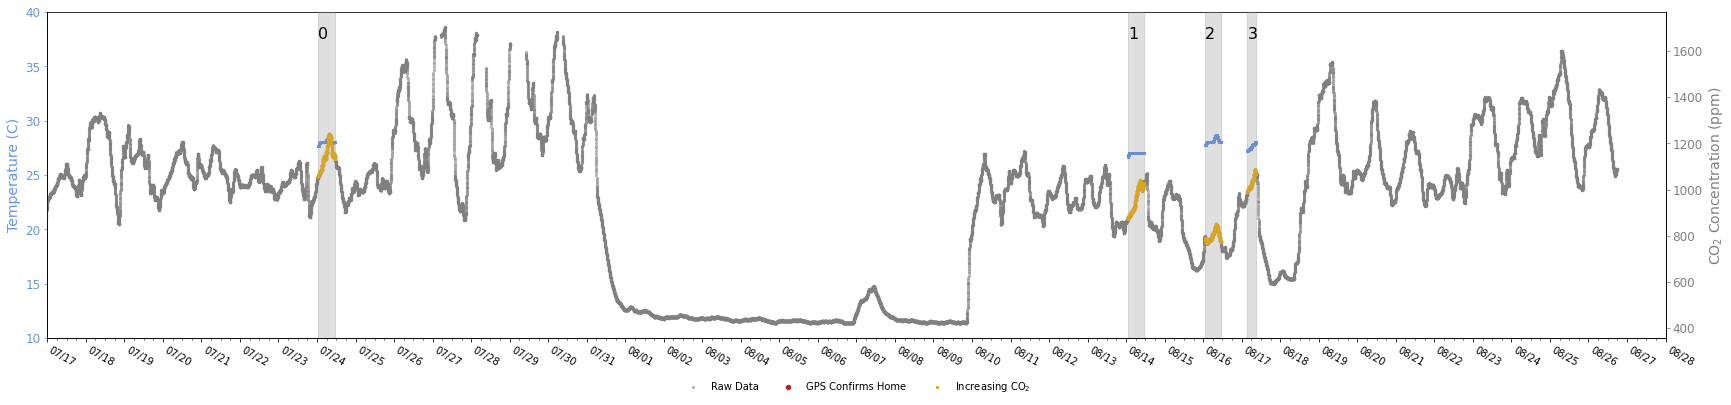

In [234]:
nv.plot_overlap(time_period=[datetime(2020,7,17),datetime(2020,8,28)])

<div class="alert-block alert alert-success">
    
More nights!

</div>

### olaxadz5

In [235]:
ox = co2_inspection("olaxadz5")

In [236]:
ox.plot_overlap(time_period=[datetime(2020,6,19),datetime(2020,8,12)])

<div class="alert-block alert alert-success">
    
We get to include more nights!
    
</div>

### qh34m4r9

In [279]:
qh = co2_inspection("qh34m4r9")

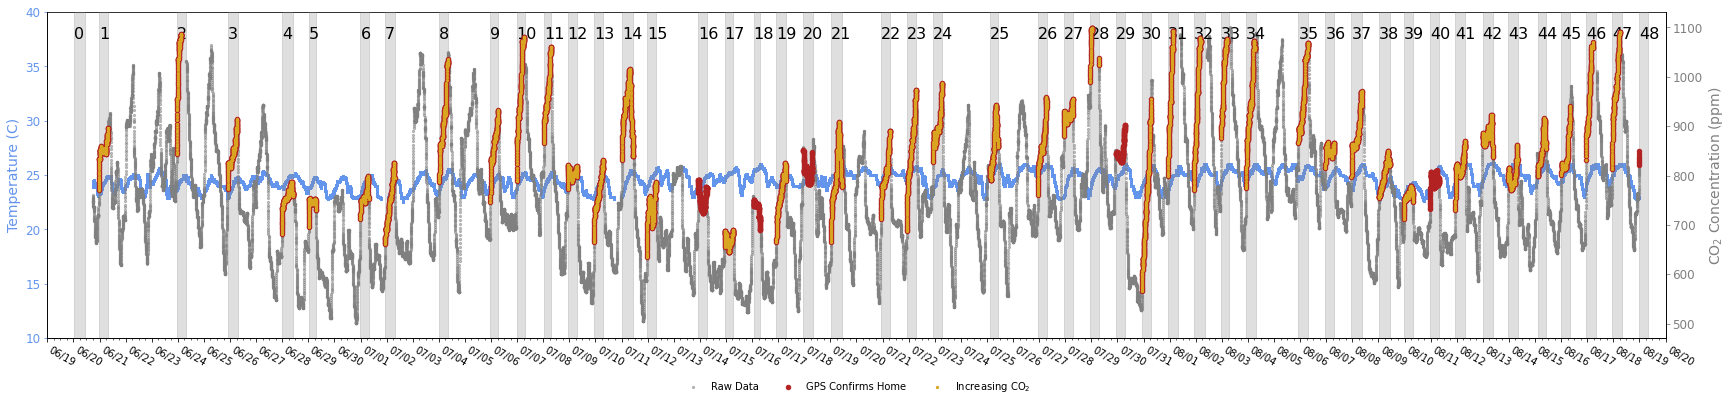

In [283]:
qh.plot_overlap(time_period=[datetime(2020,6,19),datetime(2020,8,20)])

<div class="alert-block alert alert-success">
    
A _really_ good participant and the new method seems to capture even _more_ nights of data that do seem to correspond to the Fitbit data and even the GPS data. Not sure why the `gps` filter was not able to pick up on them although there does seem to be some odd scatter.
    
</div>

### rnse61g4

In [237]:
rn = co2_inspection("rnse61g4")

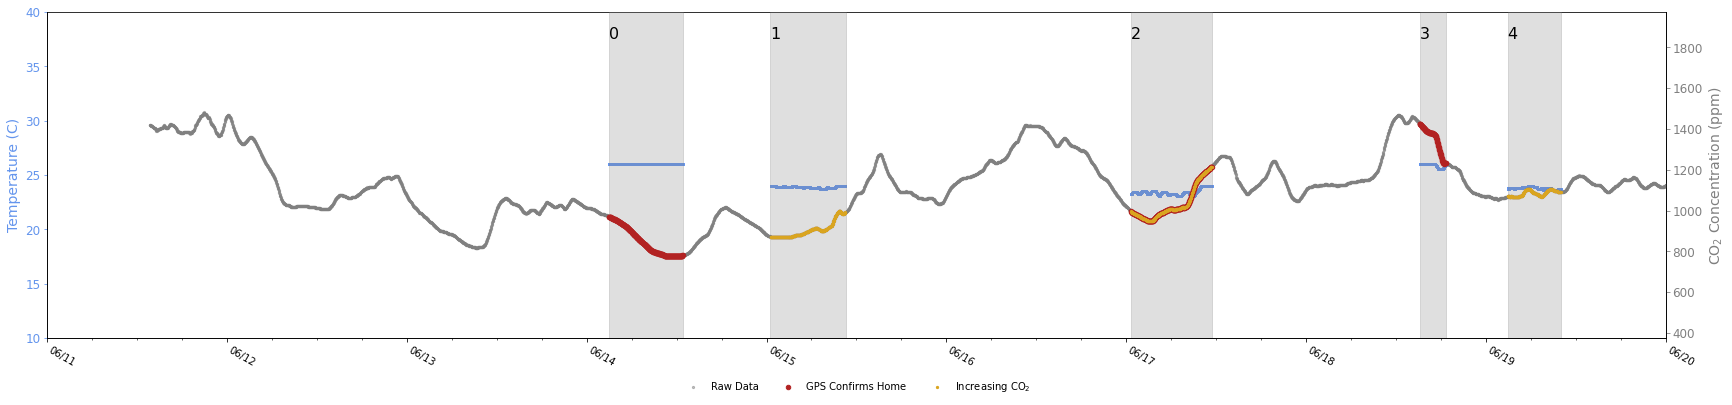

In [238]:
rn.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,6,20)])

<div class="alert-block alert alert-warning">
    
The increasing nights make a lot sense, but not the gps but it is possible the AC is keeping concentrations low.

</div>

### tlmlq19s

In [239]:
tl = co2_inspection("tlmlq19s")

In [242]:
tl.plot_overlap(time_period=[datetime(2020,6,17),datetime(2020,8,19)])

In [241]:
tl.plot_overlap(time_period=[datetime(2020,8,18),datetime(2020,9,12)])

In [318]:
bad_nights["tlmlq19s"] = tl.s.iloc[[2,55,57]]

<div class="alert-block alert alert-warning">
    
Some odd nights
    
</div>

### tmexej5v

In [244]:
tm = co2_inspection("tmexej5v")

In [247]:
tm.plot_overlap(time_period=[datetime(2020,6,11),datetime(2020,7,12)])

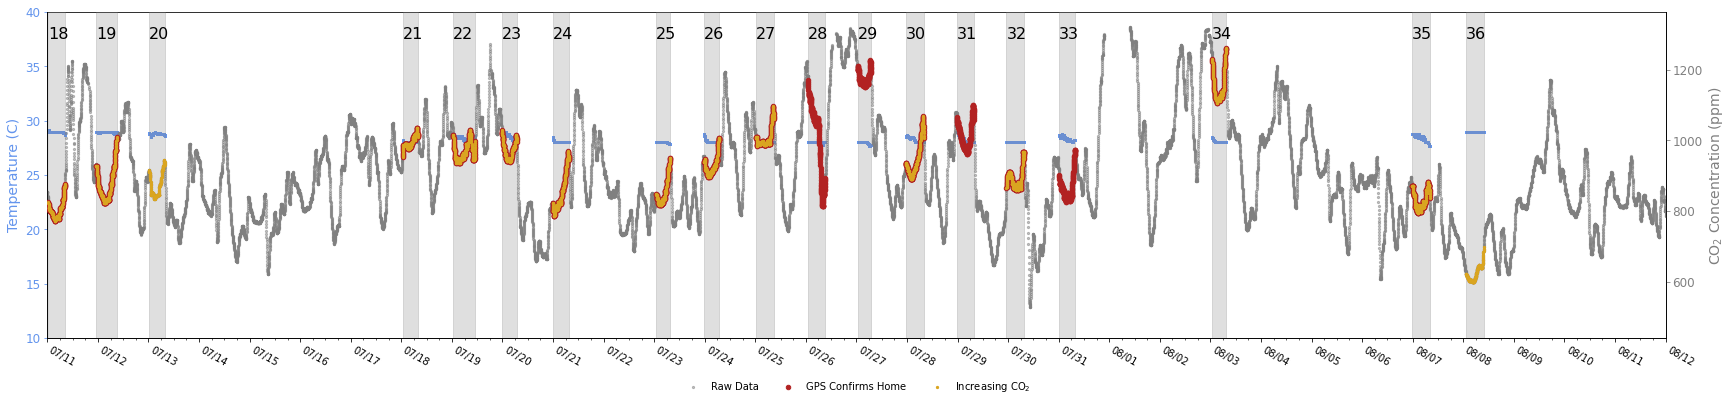

In [246]:
tm.plot_overlap(time_period=[datetime(2020,7,11),datetime(2020,8,12)])

<div class="alert-block alert alert-warning">
    
Some of these nights make no sense.
    
</div>

### vr9j5rry

In [248]:
vr = co2_inspection("vr9j5rry")

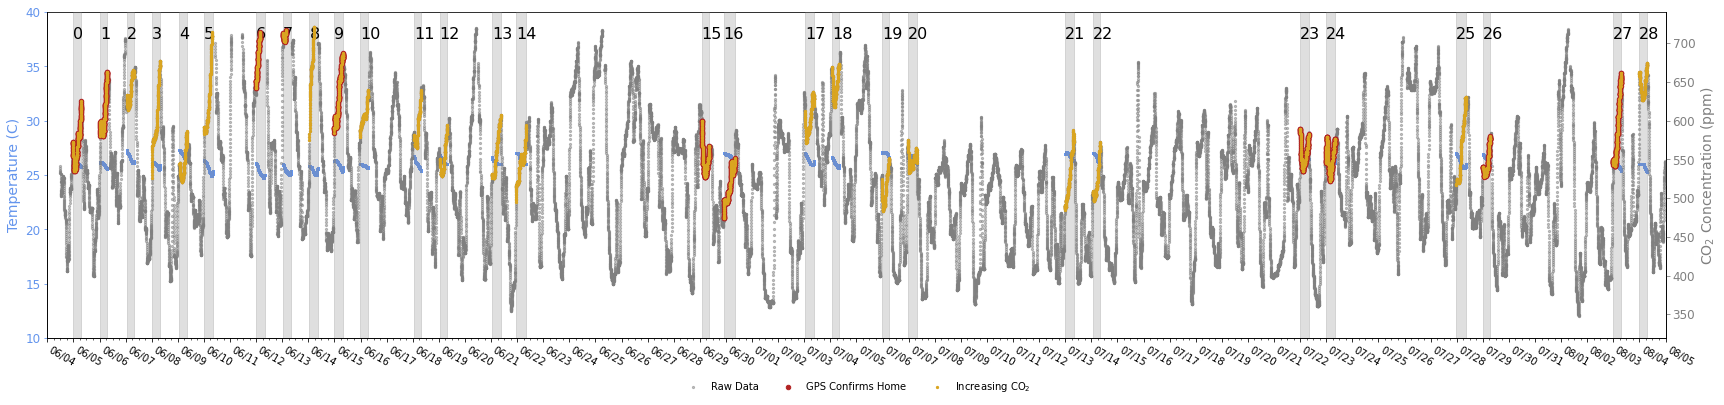

In [250]:
vr.plot_overlap(time_period=[datetime(2020,6,4),datetime(2020,8,5)])

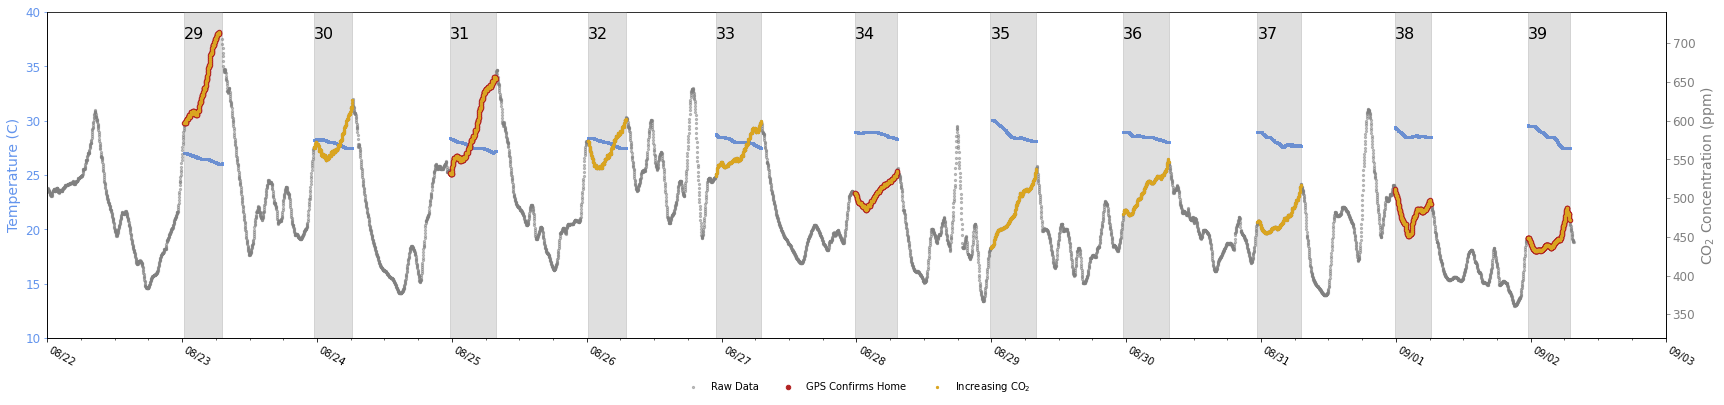

In [251]:
vr.plot_overlap(time_period=[datetime(2020,8,22),datetime(2020,9,3)])

<div class="alert-block alert alert-success">
    
Data look good and looks like we get more nights!
    
</div>

### xdbdrk6e

In [252]:
xd = co2_inspection("xdbdrk6e")

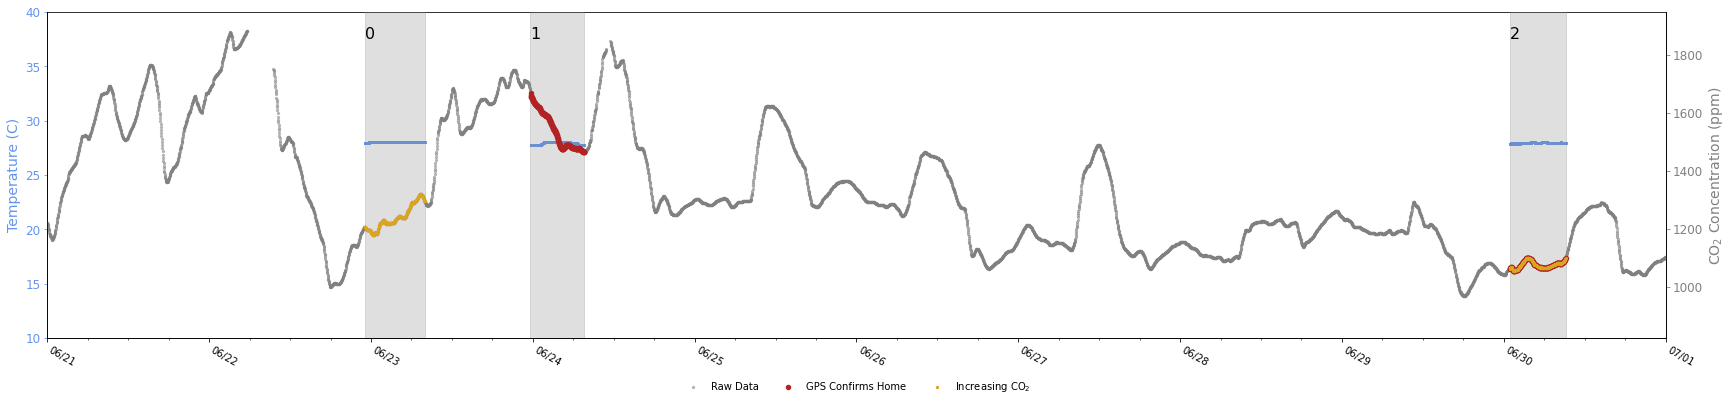

In [254]:
xd.plot_overlap(time_period=[datetime(2020,6,21),datetime(2020,7,1)])

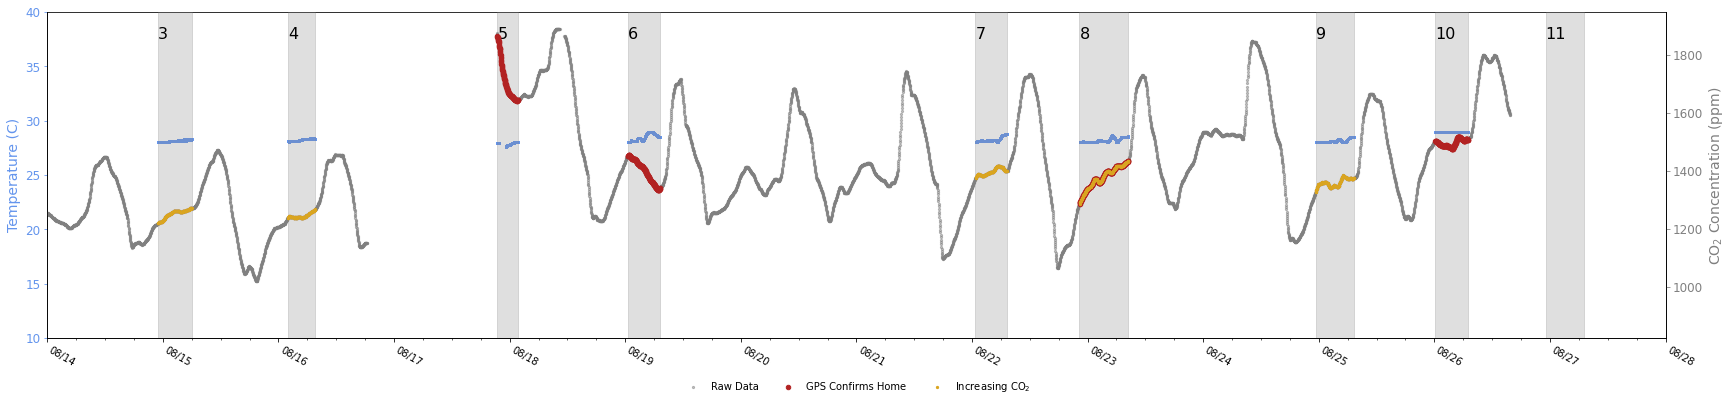

In [255]:
xd.plot_overlap(time_period=[datetime(2020,8,14),datetime(2020,8,28)])

<div class="alert-block alert alert-warning">
    
Looks like another living room beacon.

</div>

### xlw5ntd5

In [277]:
xl = co2_inspection("xlw5ntd5")

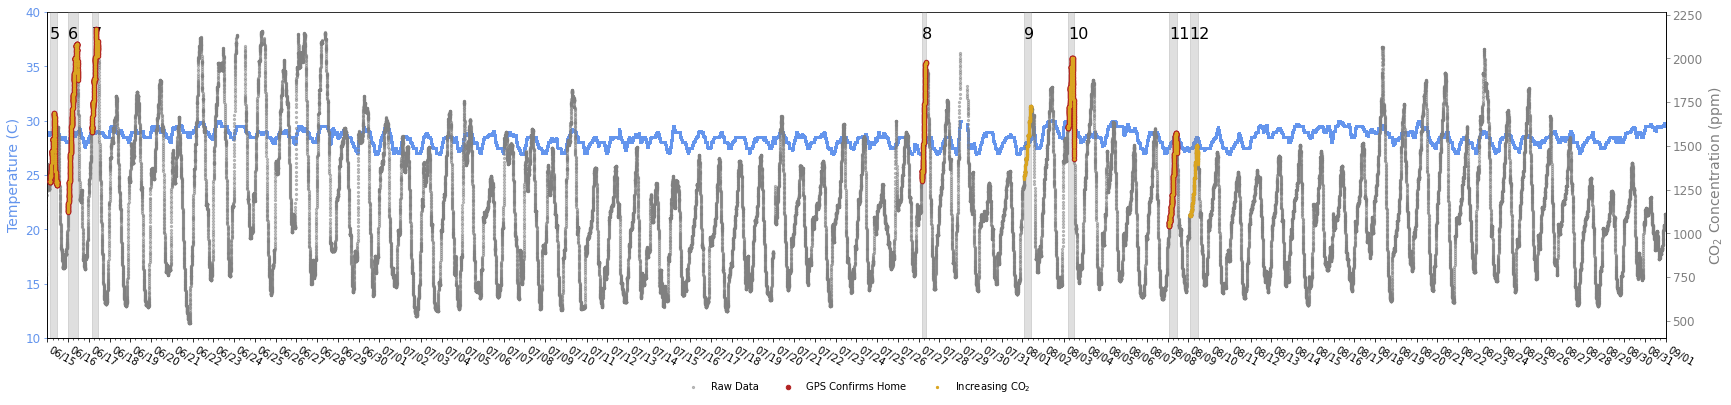

In [278]:
xl.plot_overlap(time_period=[datetime(2020,6,15),datetime(2020,9,1)])

<div class="alert-block alert alert-success">
    
There do not appear to be any issues with the model for this participant and we were able to recover 2 more nights of data.

</div>

## Test Case: Participant zdpffrox

In [291]:
zd = co2_inspection("zdpffrox")

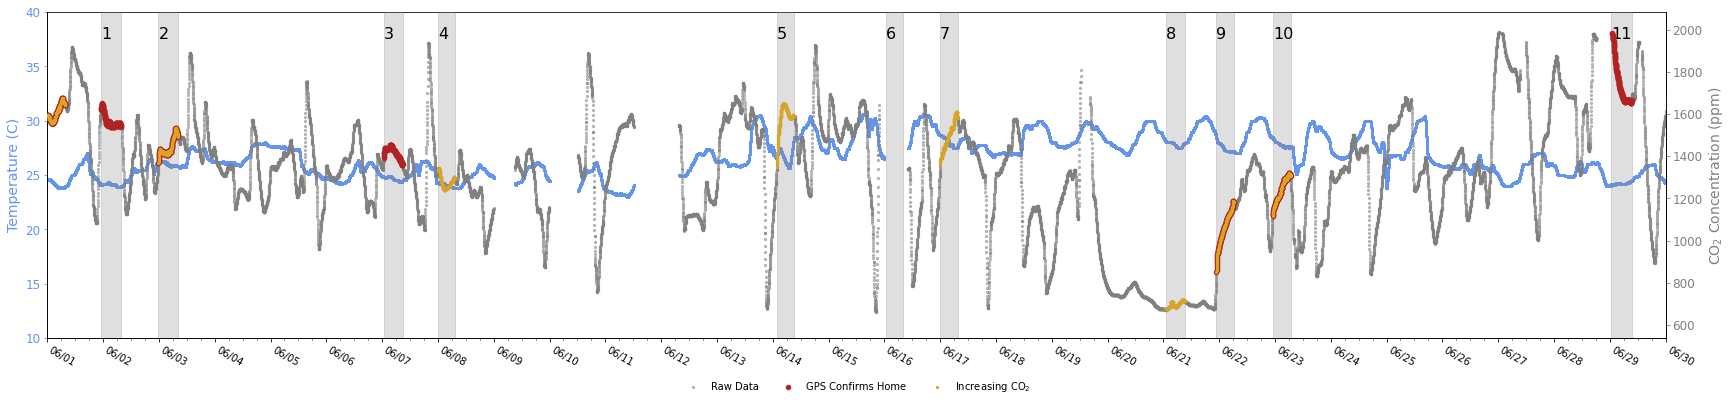

In [294]:
zd.plot_overlap(time_period=[datetime(2020,6,1),datetime(2020,6,30)])

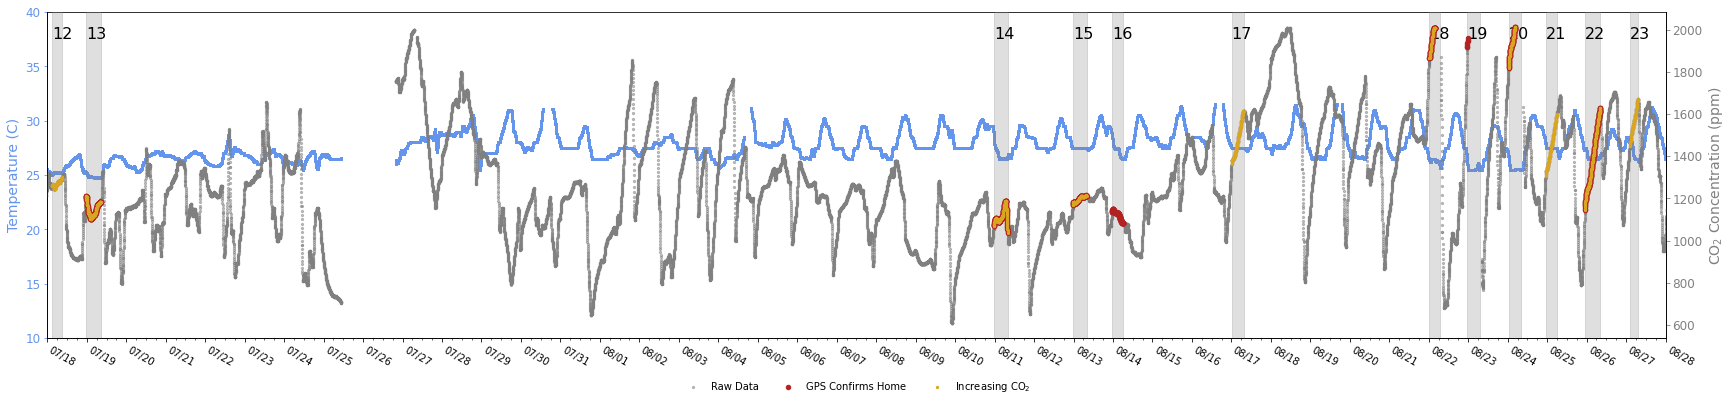

In [293]:
zd.plot_overlap(time_period=[datetime(2020,7,18),datetime(2020,8,28)])

In [350]:
bad_nights["zdpffrox"] = zd.s.iloc[[8]].values

<div class="alert-block alert alert-success">
    
Seems like it is working even on a crazy dataset like this.

</div>

## Conclusion
After closer inspection, only the following participants should be considered:

| | Beiwe | Beacon |
| :-- | :-: | :-: |
| 1 | kyj367pi | 1 |
| 2 | xlw5ntd5 | 10 |
| 3 | qh34m4r9 | 19 |
| 4 | zdpffrox | 7 |
| 5 | 9jtzsuu8 | 15 |
| 6 | e73a1pd5 | 16 |
| 7 | i31pt4b4 | 11 |
| 8 | idbkjh8u | 30 |
| 9 | tlmlq19s | 36 |
| 10 | vr9j5rry | 25 |
| 11 | lkkjddam | 21 |
| 12 | nvtfpaor | 46 |
| 13 | olaxadz5 | 38 |
| 14 | rnse61g4 | 34 |
| 15 | tmexej5v | 29 |

In [353]:
bad_nights_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in bad_nights.items() ]))
bad_nights_df.to_csv("../data/interim/bad_analysis_nights.csv")